<a href="https://colab.research.google.com/github/anjalii-s/Thesis-2026-/blob/main/Updated_Taiwan_experiment_Kuncheva_cosine_14_1_26.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.4/235.4 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 92.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.8/289.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 127.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.3/233.3 kB 22.1 MB/s eta 0:00:00

LOADING AND PREPROCESSING TAIWAN CREDIT CARD DEFAULT DATASET
✓ Dataset loaded successfully with xlrd
Dataset shape: (30000, 24)
Target distribution: {0: 23364, 1: 6636}
Default rate: 22.12%
Imbalance ratio: 3.52:1

Categorical columns (9): ['gender', 'education', 'marriage', 'repay

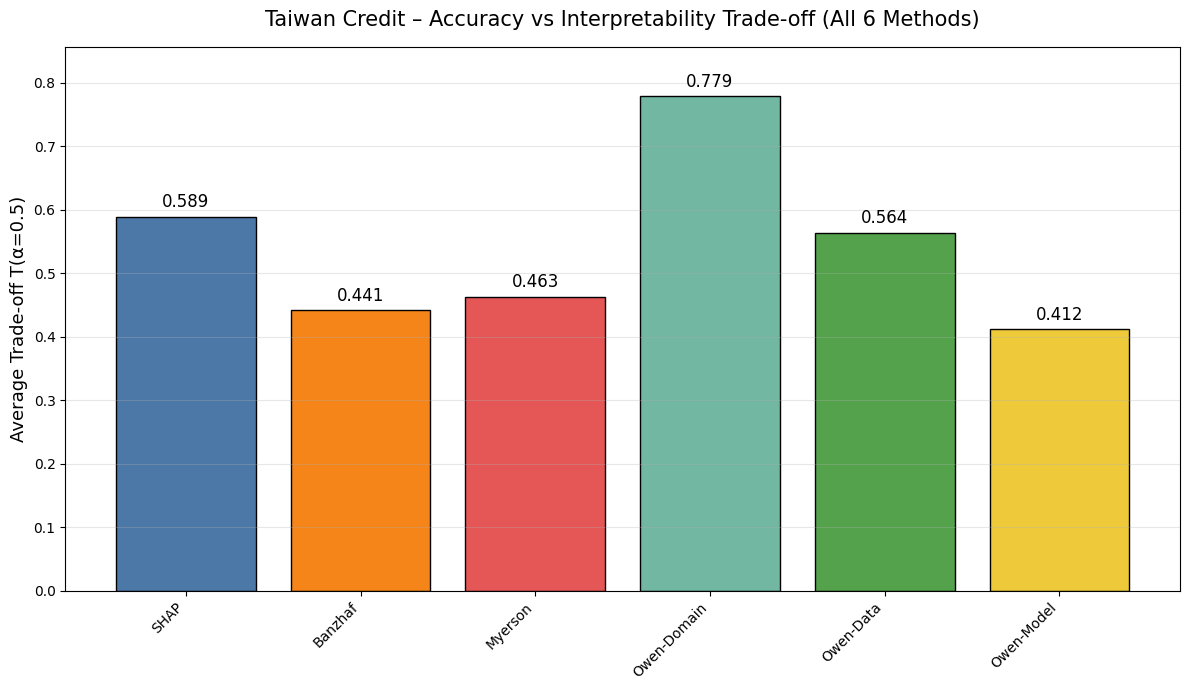

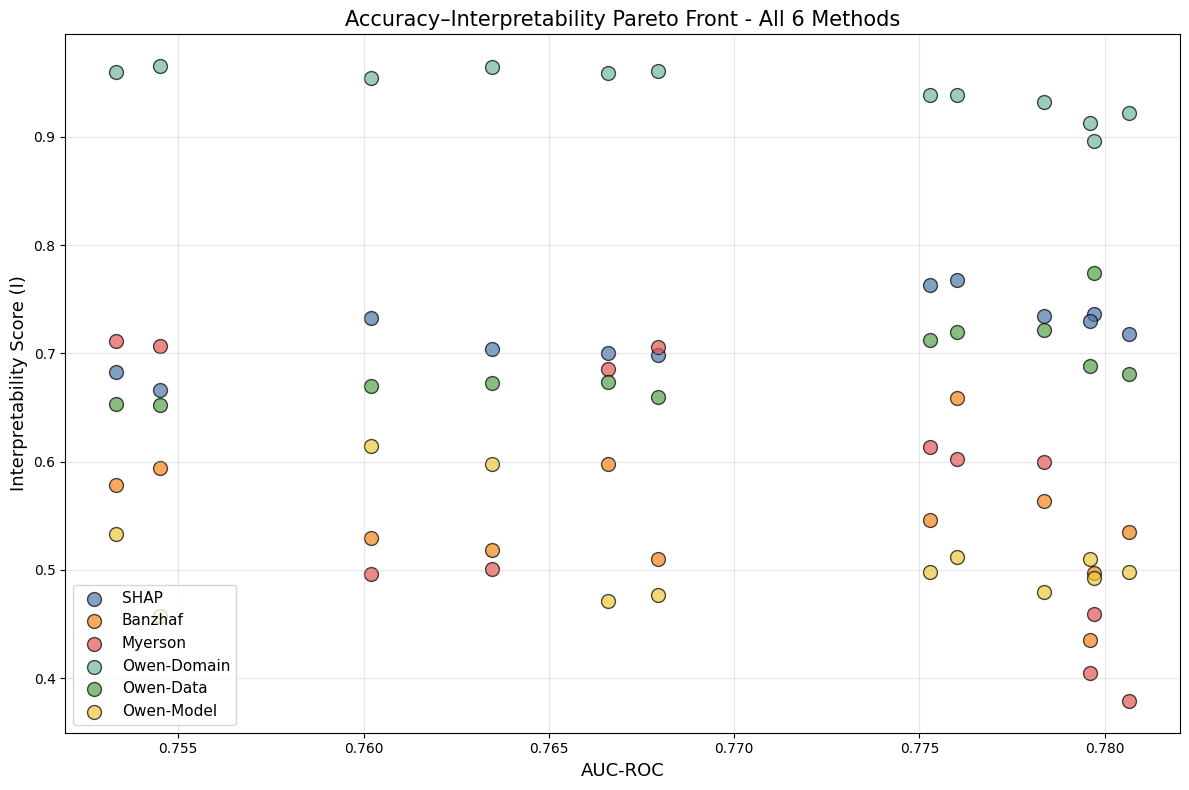

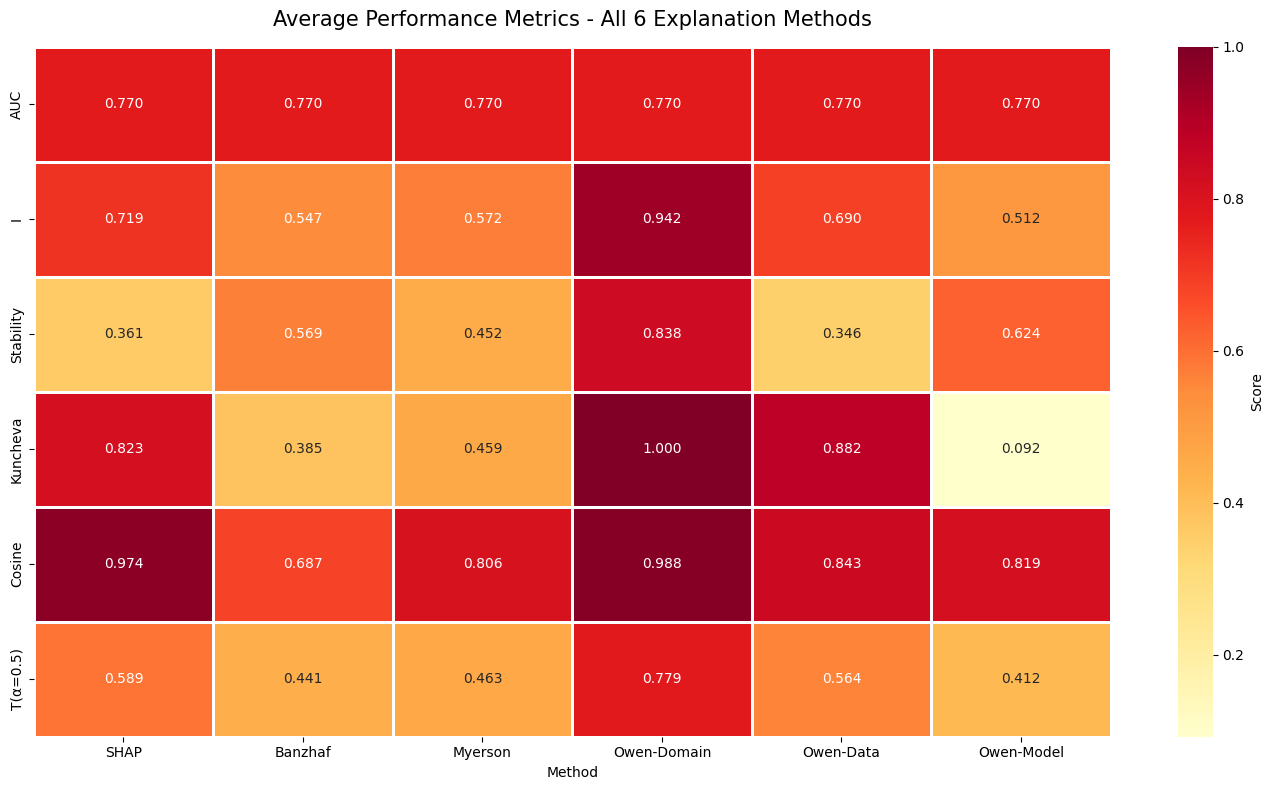

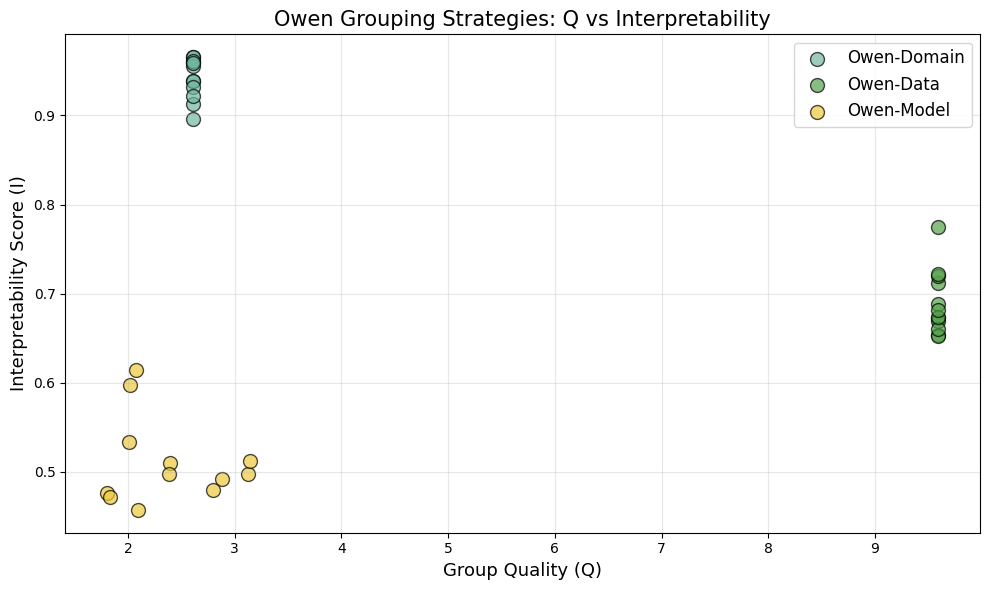


STATISTICAL ANALYSIS - ALL 6 METHODS

Friedman Test for T(α=0.5):
Methods compared: ['SHAP', 'Banzhaf', 'Myerson', 'Owen-Domain', 'Owen-Data', 'Owen-Model']
Friedman χ² = 45.5714, p = 0.000000
✓ SIGNIFICANT differences between methods

Nemenyi Post-Hoc Test (p-values):
        0       1       2       3       4       5
0  1.0000  0.0194  0.0927  0.5013  0.8370  0.0012
1  0.0194  1.0000  0.9943  0.0000  0.3632  0.9735
2  0.0927  0.9943  1.0000  0.0002  0.7159  0.7801
3  0.5013  0.0000  0.0002  1.0000  0.0379  0.0000
4  0.8370  0.3632  0.7159  0.0379  1.0000  0.0699
5  0.0012  0.9735  0.7801  0.0000  0.0699  1.0000

Pairwise Wilcoxon Tests for T(α=0.5):
SHAP vs Banzhaf: p=0.0005 (means: 0.589 vs 0.441) ✓
SHAP vs Myerson: p=0.0122 (means: 0.589 vs 0.463) ✓
SHAP vs Owen-Domain: p=0.0005 (means: 0.589 vs 0.779) ✓
Owen-Domain vs Owen-Data: p=0.0005 (means: 0.779 vs 0.564) ✓
Owen-Domain vs Owen-Model: p=0.0005 (means: 0.779 vs 0.412) ✓

UNIFIED EXPERIMENT COMPLETE!

Summary:
- Total configura

In [1]:
# ============================================================
# TAIWAN CREDIT CARD DATASET - UNIFIED GAME THEORY EXPLAINABILITY
# ============================================================


!pip install xgboost shap imbalanced-learn lightgbm scikit-posthocs xlrd openpyxl -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline
import shap
import networkx as nx
from scipy import stats
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import cosine

plt.style.use('default')
sns.set_palette("husl")
np.random.seed(42)

# ============================================================
# 1. LOAD AND PREPROCESS TAIWAN CREDIT CARD DATASET
# ============================================================
print("\n" + "="*80)
print("LOADING AND PREPROCESSING TAIWAN CREDIT CARD DEFAULT DATASET")
print("="*80)

# Load Taiwan Credit Card dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"

# Load the dataset with explicit engine
try:
    df = pd.read_excel(url, header=1, engine='openpyxl')
    print("✓ Dataset loaded successfully with openpyxl")
except:
    try:
        df = pd.read_excel(url, header=1, engine='xlrd')
        print("✓ Dataset loaded successfully with xlrd")
    except Exception as e:
        print(f"✗ Failed to load dataset: {e}")
        import urllib.request
        import os
        print("Attempting alternative download method...")
        urllib.request.urlretrieve(url, 'taiwan_credit_card.xls')
        df = pd.read_excel('taiwan_credit_card.xls', header=1, engine='openpyxl')
        print("✓ Dataset downloaded and loaded successfully")

# Clean up the dataset
df = df.rename(columns={'default payment next month': 'target'})
df = df.drop('ID', axis=1)

# Rename columns for better understanding
new_col_names = {
    'LIMIT_BAL': 'credit_limit',
    'SEX': 'gender',
    'EDUCATION': 'education',
    'MARRIAGE': 'marriage',
    'AGE': 'age',
    'PAY_0': 'repayment_status_sep',
    'PAY_2': 'repayment_status_aug',
    'PAY_3': 'repayment_status_jul',
    'PAY_4': 'repayment_status_jun',
    'PAY_5': 'repayment_status_may',
    'PAY_6': 'repayment_status_apr',
    'BILL_AMT1': 'bill_amount_sep',
    'BILL_AMT2': 'bill_amount_aug',
    'BILL_AMT3': 'bill_amount_jul',
    'BILL_AMT4': 'bill_amount_jun',
    'BILL_AMT5': 'bill_amount_may',
    'BILL_AMT6': 'bill_amount_apr',
    'PAY_AMT1': 'payment_amount_sep',
    'PAY_AMT2': 'payment_amount_aug',
    'PAY_AMT3': 'payment_amount_jul',
    'PAY_AMT4': 'payment_amount_jun',
    'PAY_AMT5': 'payment_amount_may',
    'PAY_AMT6': 'payment_amount_apr'
}

df = df.rename(columns=new_col_names)
X = df.drop('target', axis=1)
y = df['target']

print(f"Dataset shape: {df.shape}")
print(f"Target distribution: {y.value_counts().to_dict()}")
print(f"Default rate: {(y.mean() * 100):.2f}%")
print(f"Imbalance ratio: {sum(y==0)/sum(y==1):.2f}:1")

# Identify categorical and numeric columns
categorical_features = ['gender', 'education', 'marriage'] + \
                      [col for col in X.columns if 'repayment_status' in col]
numeric_features = [col for col in X.columns if col not in categorical_features]

# Convert repayment status columns to categorical
for col in categorical_features:
    if 'repayment_status' in col:
        X[col] = X[col].astype(str)

print(f"\nCategorical columns ({len(categorical_features)}): {categorical_features}")
print(f"Numeric columns ({len(numeric_features)}): {numeric_features[:10]}...")

# Create preprocessing pipeline
cat_categories = [sorted(X[col].dropna().unique().tolist()) for col in categorical_features]
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore',
                         sparse_output=False, categories=cat_categories), categorical_features),
    ('num', StandardScaler(), numeric_features)
])

# Fit preprocessor
X_processed = preprocessor.fit_transform(X)
d = X_processed.shape[1]
print(f"\nNumber of processed features: {d}")

# ============================================================
# 2. MODELS & SAMPLING STRATEGIES
# ============================================================
models = {
    'RF': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
    'XGB': xgb.XGBClassifier(n_estimators=100, max_depth=6, random_state=42,
                            eval_metric='logloss', n_jobs=-1),
    'LGB': lgb.LGBMClassifier(n_estimators=100, max_depth=6, random_state=42,
                             verbose=-1, n_jobs=-1)
}

resamplers = {
    'None': None,
    'SMOTE': SMOTE(random_state=42),
    'SMOTETomek': SMOTETomek(random_state=42),
    'CostSensitive': 'cost'
}

# Compute class weights
classes = np.unique(y)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
class_weight_dict = {int(cls): float(w) for cls, w in zip(classes, weights)}
print(f"\nClass weights: {class_weight_dict}")

# ============================================================
# 3. EXPLANATION METHODS (ALL 6 METHODS)
# ============================================================
def get_shap_reliable(pipe, X_test):
    """Get SHAP values for a trained pipeline"""
    clf = pipe.named_steps['clf']
    X_proc = pipe.named_steps['prep'].transform(X_test)
    try:
        explainer = shap.TreeExplainer(clf)
        sv = explainer.shap_values(X_proc)
        if isinstance(sv, list):
            return sv[1]
        elif sv.ndim == 3:
            return sv[:, :, 1]
        else:
            return sv
    except Exception as e:
        print(f"SHAP failed: {e}. Using permutation importance...")
        from sklearn.inspection import permutation_importance
        res = permutation_importance(clf, X_proc, pipe.predict(X_proc), n_repeats=3, random_state=42)
        return np.tile(res.importances_mean, (X_proc.shape[0], 1))

def compute_banzhaf(pipe, X_test, n_samples=5, max_instances=5):
    """Compute Banzhaf values"""
    clf = pipe.named_steps['clf']
    X_proc = pipe.named_steps['prep'].transform(X_test)
    n_feat = X_proc.shape[1]
    n_inst = min(max_instances, X_proc.shape[0])
    mat = np.zeros((n_inst, n_feat))
    for i in range(n_inst):
        x = X_proc[i:i+1]
        for f in range(n_feat):
            contrib = []
            for _ in range(n_samples):
                coal = np.random.binomial(1, 0.5, n_feat)
                x_with = x.copy()
                x_with[0, f] = x[0, f] * coal[f]
                p1 = clf.predict_proba(x_with)[0, 1]
                x_without = x.copy()
                x_without[0, f] = 0
                p0 = clf.predict_proba(x_without)[0, 1]
                contrib.append(p1 - p0)
            mat[i, f] = np.mean(contrib)
    return mat

def compute_myerson(pipe, X_test, G, alpha=0.5):
    """Compute Myerson values using feature graph"""
    shap_vals = get_shap_reliable(pipe, X_test)
    shap_mean = shap_vals.mean(axis=0)
    d = len(shap_mean)
    phi = np.zeros(d)
    for i in range(d):
        neighbors = list(G.neighbors(i))
        if len(neighbors) == 0:
            phi[i] = shap_mean[i]
        else:
            neighbor_mean = np.mean([shap_mean[j] for j in neighbors])
            phi[i] = (1 - alpha) * shap_mean[i] + alpha * neighbor_mean
    return np.tile(phi, (min(50, len(X_test)), 1))

# Owen grouping strategies
def build_domain_groups_taiwan(fnames):
    """Build domain-specific groups for Taiwan dataset"""
    groups = {
        "Domain_Demographic": [],
        "Domain_Financial": [],
        "Domain_Repayment": []
    }
    for i, name in enumerate(fnames):
        lname = name.lower()
        if any(k in lname for k in ["gender", "education", "marriage", "age"]):
            groups["Domain_Demographic"].append(i)
        if any(k in lname for k in ["credit_limit", "bill_amount", "payment_amount"]):
            groups["Domain_Financial"].append(i)
        if "repayment_status" in lname:
            groups["Domain_Repayment"].append(i)
    return {g: v for g, v in groups.items() if len(v) > 0}

def build_data_groups(X_proc, n_groups=6):
    """Build data-driven groups using correlation clustering"""
    try:
        X_proc = np.nan_to_num(X_proc, nan=0.0)
        with np.errstate(invalid='ignore'):
            corr = np.corrcoef(X_proc.T)
        corr = np.nan_to_num(corr, nan=0.0, posinf=0.0, neginf=0.0)
        np.fill_diagonal(corr, 1.0)
        corr = np.clip(corr, -1.0, 1.0)
        dist = 1 - np.abs(corr)
        dist = np.clip(dist, 0.0, 2.0)

        if X_proc.shape[1] < n_groups:
            n_groups = max(2, X_proc.shape[1] // 2)
        clustering = AgglomerativeClustering(
            n_clusters=n_groups,
            metric='precomputed',
            linkage='average'
        )
        labels = clustering.fit_predict(dist)
        groups = {}
        for idx, lab in enumerate(labels):
            groups.setdefault(f"Data_Cluster_{lab}", []).append(idx)
        return groups, np.abs(corr)
    except Exception as e:
        print(f"Warning: Data-driven grouping failed: {e}")
        n_features = X_proc.shape[1]
        default_groups = {"Data_Default": list(range(n_features))}
        return default_groups, np.eye(n_features)

def build_model_groups(shap_vals, n_groups=6):
    """Build model-driven groups using SHAP correlation"""
    try:
        shap_vals = np.nan_to_num(shap_vals, nan=0.0)
        if shap_vals.ndim == 1:
            shap_vals = shap_vals.reshape(1, -1)
        elif shap_vals.ndim == 3:
            shap_vals = shap_vals.mean(axis=2) if shap_vals.shape[2] > 1 else shap_vals.squeeze()

        if shap_vals.shape[0] < 2:
            n_features = shap_vals.shape[1] if shap_vals.shape[0] == 1 else shap_vals.shape[0]
            default_groups = {"Model_Default": list(range(n_features))}
            return default_groups, np.eye(n_features)

        with np.errstate(invalid='ignore'):
            corr = np.corrcoef(shap_vals)
        corr = np.nan_to_num(corr, nan=0.0, posinf=0.0, neginf=0.0)
        np.fill_diagonal(corr, 1.0)
        corr = np.clip(corr, -1.0, 1.0)
        dist = 1 - np.abs(corr)
        dist = np.clip(dist, 0.0, 2.0)

        n_features = corr.shape[0]
        if n_features < n_groups:
            n_groups = max(2, n_features // 2)
        clustering = AgglomerativeClustering(
            n_clusters=n_groups,
            metric='precomputed',
            linkage='average'
        )
        labels = clustering.fit_predict(dist)
        groups = {}
        for idx, lab in enumerate(labels):
            groups.setdefault(f"Model_Group_{lab}", []).append(idx)
        return groups, np.abs(corr)
    except Exception as e:
        print(f"Warning: Model-driven grouping failed: {e}")
        n_features = shap_vals.shape[1] if shap_vals.ndim > 1 else shap_vals.shape[0]
        default_groups = {"Model_Default": list(range(n_features))}
        return default_groups, np.eye(n_features)

def compute_owen_from_shap(phi, groups):
    """Redistribute SHAP values using Owen grouping"""
    d = len(phi)
    out = np.zeros(d)
    for _, feats in groups.items():
        if len(feats) == 0:
            continue
        valid_feats = [f for f in feats if f < d]
        if not valid_feats:
            continue
        total = np.sum(np.abs(phi[valid_feats]))
        per = total / len(valid_feats)
        for f in valid_feats:
            sign = np.sign(phi[f]) if phi[f] != 0 else 1
            out[f] = sign * per
    return out

def compute_Q(groups, dep):
    """Compute group quality metric Q"""
    try:
        d = dep.shape[0]
        group_id = np.full(d, -1)
        for gid, (gname, feats) in enumerate(groups.items()):
            for f in feats:
                if f < d:
                    group_id[f] = gid
        within, across = [], []
        for i in range(d):
            for j in range(i+1, d):
                if group_id[i] == group_id[j] and group_id[i] != -1:
                    within.append(dep[i, j])
                elif group_id[i] != -1 and group_id[j] != -1:
                    across.append(dep[i, j])
        if len(within) == 0 or len(across) == 0:
            return 1.0
        within_mean = np.mean(within)
        across_mean = np.mean(across)
        if across_mean == 0:
            return 1.0 if within_mean == 0 else 10.0
        return float(within_mean / across_mean)
    except:
        return 1.0

# ============================================================
# 4. METRICS
# ============================================================
def stability_cv(expl_list):
    """Compute coefficient of variation stability metric"""
    if len(expl_list) < 2:
        return 1.0
    try:
        arr = np.stack([np.abs(e) for e in expl_list])
        mean = arr.mean(axis=0) + 1e-8
        std = arr.std(axis=0)
        cv_per_feature = std / mean
        return float(np.mean(cv_per_feature))
    except:
        return 1.0

def kuncheva_index(expl_list, k=5):
    """Compute Kuncheva index for feature consistency"""
    if len(expl_list) < 2:
        return 0.0
    sets = []
    for exp in expl_list:
        try:
            imp = np.abs(exp).mean(axis=0).ravel()
            topk = min(k, len(imp))
            topk_indices = set(np.argsort(imp)[-topk:].tolist())
            sets.append(topk_indices)
        except:
            sets.append(set())
    if len(sets) < 2:
        return 0.0
    ki_values = []
    for i in range(len(sets)):
        for j in range(i + 1, len(sets)):
            intersection = len(sets[i] & sets[j])
            if k == d:
                ki = 0.0
            else:
                ki = (intersection - (k**2)/d) / (k - (k**2)/d)
            ki = max(min(ki, 1.0), -1.0)
            ki_values.append(ki)
    return float(np.mean(ki_values)) if ki_values else 0.0

def cosine_directional_consistency(expl_list):
    """Compute cosine directional consistency"""
    if len(expl_list) < 2:
        return 0.0
    mean_vecs = [np.mean(np.abs(e), axis=0).ravel() for e in expl_list]
    K = len(mean_vecs)
    cos_sims = []
    for p in range(K):
        for s in range(p + 1, K):
            v_p = mean_vecs[p]
            v_s = mean_vecs[s]
            cos = 1 - cosine(v_p, v_s)
            cos_sims.append(cos)
    if not cos_sims:
        return 0.0
    return np.mean(cos_sims)

def interpretability_score(cv, kuncheva, cosine_score, beta=1/3):
    """Compute overall interpretability score"""
    return beta * (1 - cv) + beta * kuncheva + beta * cosine_score

def normalize(s):
    """Normalize a series to [0,1]"""
    return (s - s.min()) / (s.max() - s.min() + 1e-8)

def tradeoff_metric(auc_series, I_series, alpha=0.5):
    """Compute trade-off metric between AUC and interpretability"""
    return alpha * normalize(auc_series) + (1 - alpha) * normalize(I_series)

# ============================================================
# 5. UNIFIED EXPERIMENT LOOP (ALL 6 METHODS)
# ============================================================
print("\n" + "="*80)
print("STARTING UNIFIED EXPERIMENT - ALL 6 EXPLANATION METHODS")
print("="*80)

# Build feature graph for Myerson
print("\nBuilding feature graph for Myerson value...")
X_proc = preprocessor.transform(X)
corr = np.corrcoef(X_proc.T)
G_myerson = nx.Graph()
d_graph = corr.shape[0]
G_myerson.add_nodes_from(range(d_graph))
for i in range(d_graph):
    for j in range(i+1, d_graph):
        if abs(corr[i, j]) >= 0.25:
            G_myerson.add_edge(i, j, weight=corr[i, j])
print(f"Graph built with {G_myerson.number_of_nodes()} nodes and {G_myerson.number_of_edges()} edges")

# Setup cross-validation
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
all_records = []

for mname, model in models.items():
    for sname, sampler in resamplers.items():
        print(f"\n{'='*60}")
        print(f"Processing: {mname} + {sname}")
        print(f"{'='*60}")

        aucs = []
        # Lists to store explanations for each fold
        shap_runs, banzhaf_runs, myerson_runs = [], [], []
        owen_dom_runs, owen_data_runs, owen_model_runs = [], [], []
        Q_dom_list, Q_data_list, Q_model_list = [], [], []

        for fold, (train_idx, test_idx) in enumerate(cv.split(X, y), 1):
            X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
            y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]

            # Train model once per fold
            steps = [('prep', preprocessor)]
            if sampler and sampler != 'cost':
                steps.append(('samp', sampler))
            steps.append(('clf', model))
            pipe = ImbPipeline(steps)

            if sname == 'CostSensitive':
                if mname == 'RF':
                    pipe.named_steps['clf'].set_params(class_weight=class_weight_dict)
                elif mname == 'XGB':
                    ratio = class_weight_dict[1] / class_weight_dict[0] if 0 in class_weight_dict else 1
                    pipe.named_steps['clf'].set_params(scale_pos_weight=ratio)
                elif mname == 'LGB':
                    pipe.named_steps['clf'].set_params(class_weight=class_weight_dict)

            pipe.fit(X_tr, y_tr)

            # Compute AUC (only once per fold)
            auc = roc_auc_score(y_te, pipe.predict_proba(X_te)[:, 1])
            aucs.append(auc)
            print(f" Fold {fold} | {mname}+{sname:15} → AUC: {auc:.4f}")

            # Sample instances for explanations
            X_sample = X_te.sample(n=min(50, len(X_te)), random_state=42)

            # Get feature names
            fnames = preprocessor.get_feature_names_out()

            # 1. SHAP values
            try:
                shap_vals = get_shap_reliable(pipe, X_sample)
                shap_runs.append(shap_vals)
            except Exception as e:
                print(f"  SHAP failed: {e}")
                n_features = preprocessor.transform(X_sample[:1]).shape[1]
                shap_runs.append(np.zeros((len(X_sample), n_features)))
                shap_vals = None

            # 2. Banzhaf values
            try:
                banzhaf_vals = compute_banzhaf(pipe, X_sample)
                banzhaf_runs.append(banzhaf_vals)
            except Exception as e:
                print(f"  Banzhaf failed: {e}")
                n_features = preprocessor.transform(X_sample[:1]).shape[1]
                banzhaf_runs.append(np.zeros((min(5, len(X_sample)), n_features)))

            # 3. Myerson values
            try:
                if shap_vals is not None:
                    myerson_vals = compute_myerson(pipe, X_sample, G_myerson)
                else:
                    # Fallback if SHAP failed
                    myerson_vals = np.zeros((min(50, len(X_sample)), d))
                myerson_runs.append(myerson_vals)
            except Exception as e:
                print(f"  Myerson failed: {e}")
                n_features = preprocessor.transform(X_sample[:1]).shape[1]
                myerson_runs.append(np.zeros((min(50, len(X_sample)), n_features)))

            # 4. Owen-Domain values (using domain groups)
            try:
                dom_groups = build_domain_groups_taiwan(fnames)
                if shap_vals is not None:
                    phi = np.mean(shap_vals, axis=0)
                    owen_dom = np.tile(compute_owen_from_shap(phi, dom_groups), (len(X_sample), 1))
                else:
                    owen_dom = np.zeros((len(X_sample), d))
                owen_dom_runs.append(owen_dom)

                # Compute Q for domain groups
                X_tr_proc = preprocessor.transform(X_tr)
                corr_tr = np.abs(np.corrcoef(X_tr_proc.T))
                corr_tr = np.nan_to_num(corr_tr, nan=0.0)
                Q_dom_list.append(compute_Q(dom_groups, corr_tr))
            except Exception as e:
                print(f"  Owen-Domain failed: {e}")
                owen_dom_runs.append(np.zeros((len(X_sample), d)))
                Q_dom_list.append(1.0)

            # 5. Owen-Data values (using data-driven groups)
            try:
                X_tr_proc = preprocessor.transform(X_tr)
                data_groups, dep_data = build_data_groups(X_tr_proc)
                if shap_vals is not None:
                    phi = np.mean(shap_vals, axis=0)
                    owen_data = np.tile(compute_owen_from_shap(phi, data_groups), (len(X_sample), 1))
                else:
                    owen_data = np.zeros((len(X_sample), d))
                owen_data_runs.append(owen_data)
                Q_data_list.append(compute_Q(data_groups, dep_data))
            except Exception as e:
                print(f"  Owen-Data failed: {e}")
                owen_data_runs.append(np.zeros((len(X_sample), d)))
                Q_data_list.append(1.0)

            # 6. Owen-Model values (using model-driven groups)
            try:
                if shap_vals is not None:
                    bg_sample = X_tr.sample(n=min(100, len(X_tr)), random_state=42)
                    shap_bg = get_shap_reliable(pipe, bg_sample)
                    model_groups, dep_mod = build_model_groups(shap_bg)
                    phi = np.mean(shap_vals, axis=0)
                    owen_model = np.tile(compute_owen_from_shap(phi, model_groups), (len(X_sample), 1))
                else:
                    owen_model = np.zeros((len(X_sample), d))
                    model_groups, dep_mod = {"Model_Default": list(range(d))}, np.eye(d)
                owen_model_runs.append(owen_model)
                Q_model_list.append(compute_Q(model_groups, dep_mod))
            except Exception as e:
                print(f"  Owen-Model failed: {e}")
                owen_model_runs.append(np.zeros((len(X_sample), d)))
                Q_model_list.append(1.0)

        # Compute mean AUC for this model-sampler combination
        auc_mean = np.mean(aucs)

        # Compute metrics for each explanation method
        explanation_methods = [
            ('SHAP', shap_runs),
            ('Banzhaf', banzhaf_runs),
            ('Myerson', myerson_runs),
            ('Owen-Domain', owen_dom_runs),
            ('Owen-Data', owen_data_runs),
            ('Owen-Model', owen_model_runs)
        ]

        Q_values = {
            'Owen-Domain': np.mean(Q_dom_list) if Q_dom_list else 1.0,
            'Owen-Data': np.mean(Q_data_list) if Q_data_list else 1.0,
            'Owen-Model': np.mean(Q_model_list) if Q_model_list else 1.0
        }

        for method_name, runs in explanation_methods:
            cv_val = stability_cv(runs)
            kun_val = kuncheva_index(runs, k=5)
            cos_val = cosine_directional_consistency(runs)
            I = interpretability_score(cv_val, kun_val, cos_val)

            record = {
                'Model': mname,
                'Sampler': sname,
                'Method': method_name,
                'AUC': auc_mean,  # Same AUC for all methods from this model-sampler
                'CV': cv_val,
                'Stability': 1 - cv_val,
                'Kuncheva': kun_val,
                'Cosine': cos_val,
                'I': I,
                'Q': Q_values.get(method_name, np.nan)
            }
            all_records.append(record)

# ============================================================
# 6. PROCESS AND SAVE RESULTS
# ============================================================
if all_records:
    metrics = pd.DataFrame(all_records)
    metrics['T(α=0.5)'] = tradeoff_metric(metrics['AUC'], metrics['I'])

    print("\n" + "="*80)
    print("COMPLETE RESULTS - ALL 6 EXPLANATION METHODS")
    print("="*80)
    print(metrics.round(4).to_string(index=False))

    metrics.to_csv('taiwan_unified_results.csv', index=False)
    print("\n✓ Results saved to: taiwan_unified_results.csv")

# ============================================================
# 7. VISUALIZATIONS
# ============================================================
if not metrics.empty:
    print("\n" + "="*80)
    print("GENERATING VISUALIZATIONS")
    print("="*80)

    colors = {
        'SHAP': '#4C78A8',
        'Banzhaf': '#F58518',
        'Myerson': '#E45756',
        'Owen-Domain': '#72B7A2',
        'Owen-Data': '#54A24B',
        'Owen-Model': '#EECA3B'
    }

    # 1. Average Trade-off by Method
    plt.figure(figsize=(12, 7))
    method_order = ['SHAP', 'Banzhaf', 'Myerson', 'Owen-Domain', 'Owen-Data', 'Owen-Model']
    method_avg = metrics.groupby('Method')['T(α=0.5)'].mean().reindex(method_order)
    bars = plt.bar(method_avg.index, method_avg.values,
                   color=[colors[m] for m in method_avg.index], edgecolor='black')
    plt.bar_label(bars, fmt='%.3f', fontsize=12, padding=4)
    plt.ylabel("Average Trade-off T(α=0.5)", fontsize=13)
    plt.title("Taiwan Credit – Accuracy vs Interpretability Trade-off (All 6 Methods)",
              fontsize=15, pad=15)
    plt.ylim(0, method_avg.max() * 1.1)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig('taiwan_all_methods_tradeoff.png', dpi=300)
    plt.show()

    # 2. Pareto Front: AUC vs I
    plt.figure(figsize=(12, 8))
    for method in method_order:
        if method in metrics['Method'].unique():
            sub = metrics[metrics['Method'] == method]
            plt.scatter(sub['AUC'], sub['I'], s=100, label=method,
                       color=colors[method], alpha=0.7, edgecolors='black')
    plt.xlabel("AUC-ROC", fontsize=13)
    plt.ylabel("Interpretability Score (I)", fontsize=13)
    plt.title("Accuracy–Interpretability Pareto Front - All 6 Methods", fontsize=15)
    plt.legend(fontsize=11, loc='best')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('taiwan_all_methods_pareto.png', dpi=300)
    plt.show()

    # 3. Heatmap of average metrics
    plt.figure(figsize=(14, 8))
    heatmap_data = metrics.groupby('Method').agg({
        'AUC': 'mean',
        'I': 'mean',
        'Stability': 'mean',
        'Kuncheva': 'mean',
        'Cosine': 'mean',
        'T(α=0.5)': 'mean'
    }).reindex(method_order).T

    sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='YlOrRd',
                linewidths=1, linecolor='white', cbar_kws={'label': 'Score'})
    plt.title("Average Performance Metrics - All 6 Explanation Methods", fontsize=15, pad=15)
    plt.tight_layout()
    plt.savefig('taiwan_all_methods_heatmap.png', dpi=300)
    plt.show()

    # 4. Owen Grouping Comparison (Q vs I)
    owen_methods = ['Owen-Domain', 'Owen-Data', 'Owen-Model']
    if any(m in metrics['Method'].unique() for m in owen_methods):
        plt.figure(figsize=(10, 6))
        owen_data = metrics[metrics['Method'].isin(owen_methods)]

        for method in owen_methods:
            sub = owen_data[owen_data['Method'] == method]
            plt.scatter(sub['Q'], sub['I'], s=100, label=method,
                       color=colors[method], alpha=0.7, edgecolors='black')

        plt.xlabel("Group Quality (Q)", fontsize=13)
        plt.ylabel("Interpretability Score (I)", fontsize=13)
        plt.title("Owen Grouping Strategies: Q vs Interpretability", fontsize=15)
        plt.legend(fontsize=12)
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.savefig('taiwan_owen_q_vs_i_all.png', dpi=300)
        plt.show()

# ============================================================
# 8. STATISTICAL ANALYSIS
# ============================================================
print("\n" + "="*80)
print("STATISTICAL ANALYSIS - ALL 6 METHODS")
print("="*80)

from scipy.stats import friedmanchisquare, wilcoxon
import scikit_posthocs as sp

# Friedman test for T(α=0.5)
print("\nFriedman Test for T(α=0.5):")
pivoted = metrics.pivot_table(
    values='T(α=0.5)',
    index=['Model', 'Sampler'],
    columns='Method',
    aggfunc='mean'
)

# Keep only methods with complete data for all configurations
complete_methods = pivoted.dropna(axis=1, how='any').columns.tolist()
complete_methods = [m for m in method_order if m in complete_methods]

if len(complete_methods) >= 3:
    data_matrix = pivoted[complete_methods].values

    # Friedman test
    stat, p_value = friedmanchisquare(*[data_matrix[:, i] for i in range(data_matrix.shape[1])])
    print(f"Methods compared: {complete_methods}")
    print(f"Friedman χ² = {stat:.4f}, p = {p_value:.6f}")

    if p_value < 0.05:
        print("✓ SIGNIFICANT differences between methods")

        # Post-hoc Nemenyi
        nemenyi_results = sp.posthoc_nemenyi_friedman(data_matrix)
        print("\nNemenyi Post-Hoc Test (p-values):")
        print(nemenyi_results.round(4))
    else:
        print("✗ No significant differences")
else:
    print("Insufficient complete data for Friedman test")

# Pairwise Wilcoxon tests for key comparisons
print("\nPairwise Wilcoxon Tests for T(α=0.5):")
key_pairs = [
    ('SHAP', 'Banzhaf'),
    ('SHAP', 'Myerson'),
    ('SHAP', 'Owen-Domain'),
    ('Owen-Domain', 'Owen-Data'),
    ('Owen-Domain', 'Owen-Model')
]

for method1, method2 in key_pairs:
    if method1 in metrics['Method'].values and method2 in metrics['Method'].values:
        data1 = metrics[metrics['Method'] == method1]['T(α=0.5)'].values
        data2 = metrics[metrics['Method'] == method2]['T(α=0.5)'].values

        if len(data1) > 1 and len(data2) > 1:
            stat, p_value = wilcoxon(data1, data2) if len(data1) == len(data2) else (np.nan, np.nan)
            mean1, mean2 = np.mean(data1), np.mean(data2)
            sig = "✓" if p_value < 0.05 else "✗"
            print(f"{method1} vs {method2}: p={p_value:.4f} (means: {mean1:.3f} vs {mean2:.3f}) {sig}")

print("\n" + "="*80)
print("UNIFIED EXPERIMENT COMPLETE!")
print("="*80)
print("\nSummary:")
print(f"- Total configurations: {len(models) * len(resamplers)}")
print(f"- Total method comparisons: {len(all_records)}")
print(f"- All 6 methods: SHAP, Banzhaf, Myerson, Owen-Domain, Owen-Data, Owen-Model")
print(f"- Each model-sampler trained only once per fold")
print(f"- Consistent AUC values across all explanation methods")


CONCISE STATISTICAL ANALYSIS - ALL 6 METHODS
✓ Unified results loaded successfully
Shape: (72, 11), Methods: 6

1. SPEARMAN CORRELATION (AUC vs I):
----------------------------------------
Overall: ρ = -0.0691, p = 0.5640
  ✗ Not significant
Banzhaf        : ρ = -0.3706, p = 0.2356 ✗ (-) Moderate
Myerson        : ρ = -0.7343, p = 0.0065 ✓ (-) Strong
Owen-Data      : ρ = 0.8042, p = 0.0016 ✓ (+) Strong
Owen-Domain    : ρ = -0.8601, p = 0.0003 ✓ (-) Strong
Owen-Model     : ρ = -0.1259, p = 0.6967 ✗ (-) Weak
SHAP           : ρ = 0.5944, p = 0.0415 ✓ (+) Moderate


2. LEVENE'S TEST (Equal Variances):
----------------------------------------
AUC       : W = 0.0000, p = 1.0000 → Equal variances ✓
I         : W = 7.2392, p = 0.0000 → Unequal variances ✗
T(α=0.5)  : W = 0.8747, p = 0.5030 → Equal variances ✓


3. NORMALITY TESTS (Shapiro-Wilk):
----------------------------------------

AUC:
  Banzhaf        : W = 0.8896, p = 0.1166 → Normal ✓
  Myerson        : W = 0.8896, p = 0.1166 → Normal

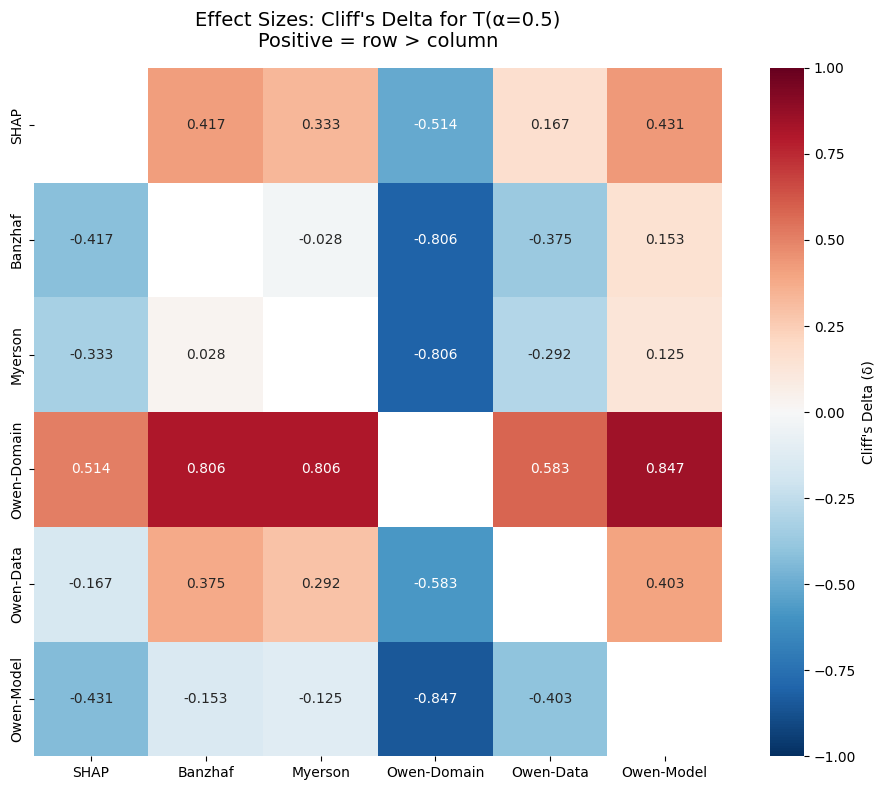



7. QUICK INTERPRETATION:
----------------------------------------

AUC:
  Best: Banzhaf = 0.7696
  Worst: Banzhaf = 0.7696
  Range: 0.0000

I:
  Best: Owen-Domain = 0.9422
  Worst: Owen-Model = 0.5117
  Range: 0.4306

T(α=0.5):
  Best: Owen-Domain = 0.7786
  Worst: Owen-Model = 0.4116
  Range: 0.3670

SHAP vs Others (Trade-off):
  SHAP mean: 0.5887
  Others mean: 0.5317
  Difference: 0.0570

STATISTICAL ANALYSIS COMPLETE


In [3]:
# ============================================================
# CONCISE STATISTICAL ANALYSIS - UNIFIED EXPERIMENT
# ============================================================

print("\n" + "="*80)
print("CONCISE STATISTICAL ANALYSIS - ALL 6 METHODS")
print("="*80)

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Load unified results
try:
    metrics = pd.read_csv('taiwan_unified_results.csv')
    print("✓ Unified results loaded successfully")
    print(f"Shape: {metrics.shape}, Methods: {metrics['Method'].nunique()}")
except:
    print("⚠ Could not load results, using in-memory metrics")
    # If metrics is already in memory from previous run
    pass

# Ensure we have the required columns
required_cols = ['Method', 'AUC', 'I', 'T(α=0.5)']
if all(col in metrics.columns for col in required_cols):

    # 1. SPEARMAN CORRELATION
    print("\n1. SPEARMAN CORRELATION (AUC vs I):")
    print("-" * 40)

    # Overall correlation
    rho, pval = stats.spearmanr(metrics['AUC'], metrics['I'])
    print(f"Overall: ρ = {rho:.4f}, p = {pval:.4f}")
    print(f"  {'✓' if pval < 0.05 else '✗'} {'Significant' if pval < 0.05 else 'Not significant'}")

    # By method
    methods = metrics['Method'].unique()
    for method in sorted(methods):
        subset = metrics[metrics['Method'] == method]
        if len(subset) >= 3:
            rho, pval = stats.spearmanr(subset['AUC'], subset['I'])
            sig = "✓" if pval < 0.05 else "✗"
            dir = "(+)" if rho > 0 else "(-)" if rho < 0 else "(0)"
            strength = "Strong" if abs(rho) >= 0.7 else "Moderate" if abs(rho) >= 0.3 else "Weak"
            print(f"{method:15}: ρ = {rho:.4f}, p = {pval:.4f} {sig} {dir} {strength}")

    # 2. LEVENE'S TEST (Equal Variances)
    print("\n\n2. LEVENE'S TEST (Equal Variances):")
    print("-" * 40)

    for metric in ['AUC', 'I', 'T(α=0.5)']:
        groups = [metrics[metrics['Method'] == method][metric].values
                 for method in methods if len(metrics[metrics['Method'] == method]) >= 3]
        group_labels = [method for method in methods if len(metrics[metrics['Method'] == method]) >= 3]

        if len(groups) >= 2:
            stat, pval = stats.levene(*groups)
            result = "Equal variances ✓" if pval > 0.05 else "Unequal variances ✗"
            print(f"{metric:10}: W = {stat:.4f}, p = {pval:.4f} → {result}")

    # 3. NORMALITY TESTS (Shapiro-Wilk)
    print("\n\n3. NORMALITY TESTS (Shapiro-Wilk):")
    print("-" * 40)

    for metric in ['AUC', 'I', 'T(α=0.5)']:
        print(f"\n{metric}:")
        for method in sorted(methods):
            data = metrics[metrics['Method'] == method][metric].values
            if len(data) >= 3 and len(data) <= 5000:
                stat, pval = stats.shapiro(data)
                normal = "Normal ✓" if pval > 0.05 else "Non-normal ✗"
                print(f"  {method:15}: W = {stat:.4f}, p = {pval:.4f} → {normal}")

    # 4. CLIFF'S DELTA EFFECT SIZES
    print("\n\n4. CLIFF'S DELTA EFFECT SIZES:")
    print("-" * 40)

    def cliffs_delta(x, y):
        """Calculate Cliff's delta effect size"""
        nx, ny = len(x), len(y)
        greater = sum(1 for i in x for j in y if i > j)
        less = sum(1 for i in x for j in y if i < j)
        return (greater - less) / (nx * ny)

    def interpret_delta(delta):
        """Interpret Cliff's delta magnitude"""
        abs_delta = abs(delta)
        if abs_delta < 0.147: return "negligible"
        elif abs_delta < 0.33: return "small"
        elif abs_delta < 0.474: return "medium"
        else: return "large"

    # Key pairwise comparisons
    key_pairs = [
        ('SHAP', 'Banzhaf'),
        ('SHAP', 'Myerson'),
        ('SHAP', 'Owen-Domain'),
        ('SHAP', 'Owen-Data'),
        ('SHAP', 'Owen-Model'),
        ('Owen-Domain', 'Owen-Data'),
        ('Owen-Domain', 'Owen-Model'),
        ('Banzhaf', 'Myerson')
    ]

    print("\nTrade-off (T) Effect Sizes:")
    for method1, method2 in key_pairs:
        if method1 in metrics['Method'].values and method2 in metrics['Method'].values:
            data1 = metrics[metrics['Method'] == method1]['T(α=0.5)'].values
            data2 = metrics[metrics['Method'] == method2]['T(α=0.5)'].values

            if len(data1) > 1 and len(data2) > 1:
                delta = cliffs_delta(data1, data2)
                magnitude = interpret_delta(delta)
                direction = f"{method1}>{method2}" if delta > 0 else f"{method2}>{method1}"
                print(f"  {method1:15} vs {method2:15}: δ = {delta:.4f} ({magnitude}, {direction})")

    print("\nInterpretability (I) Effect Sizes:")
    for method1, method2 in key_pairs:
        if method1 in metrics['Method'].values and method2 in metrics['Method'].values:
            data1 = metrics[metrics['Method'] == method1]['I'].values
            data2 = metrics[metrics['Method'] == method2]['I'].values

            if len(data1) > 1 and len(data2) > 1:
                delta = cliffs_delta(data1, data2)
                magnitude = interpret_delta(delta)
                direction = f"{method1}>{method2}" if delta > 0 else f"{method2}>{method1}"
                print(f"  {method1:15} vs {method2:15}: δ = {delta:.4f} ({magnitude}, {direction})")

    # 5. SUMMARY STATISTICS TABLE
    print("\n\n5. SUMMARY STATISTICS BY METHOD:")
    print("-" * 40)

    summary = metrics.groupby('Method').agg({
        'AUC': ['mean', 'std', 'count'],
        'I': ['mean', 'std'],
        'T(α=0.5)': ['mean', 'std', 'min', 'max']
    }).round(4)

    print("\nMean ± SD (N = count):")
    print(summary.to_string())

    # 6. VISUALIZATION: Effect Size Heatmap
    print("\n\n6. VISUALIZING EFFECT SIZES...")

    # Create effect size matrix for T(α=0.5)
    effect_matrix = pd.DataFrame(index=methods, columns=methods)

    for i, method1 in enumerate(methods):
        for j, method2 in enumerate(methods):
            if i != j:
                data1 = metrics[metrics['Method'] == method1]['T(α=0.5)'].values
                data2 = metrics[metrics['Method'] == method2]['T(α=0.5)'].values

                if len(data1) > 1 and len(data2) > 1:
                    delta = cliffs_delta(data1, data2)
                    effect_matrix.loc[method1, method2] = delta
                else:
                    effect_matrix.loc[method1, method2] = np.nan

    # Convert to float and plot
    effect_matrix = effect_matrix.astype(float)

    plt.figure(figsize=(10, 8))
    sns.heatmap(effect_matrix, annot=True, fmt='.3f', cmap='RdBu_r',
                center=0, vmin=-1, vmax=1, square=True,
                cbar_kws={'label': "Cliff's Delta (δ)"})
    plt.title("Effect Sizes: Cliff's Delta for T(α=0.5)\nPositive = row > column",
              fontsize=14, pad=15)
    plt.tight_layout()
    plt.savefig('effect_sizes_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 7. QUICK INTERPRETATION
    print("\n\n7. QUICK INTERPRETATION:")
    print("-" * 40)

    # Find best method for each metric
    for metric in ['AUC', 'I', 'T(α=0.5)']:
        best_method = metrics.groupby('Method')[metric].mean().idxmax()
        best_value = metrics.groupby('Method')[metric].mean().max()
        worst_method = metrics.groupby('Method')[metric].mean().idxmin()
        worst_value = metrics.groupby('Method')[metric].mean().min()

        print(f"\n{metric}:")
        print(f"  Best: {best_method} = {best_value:.4f}")
        print(f"  Worst: {worst_method} = {worst_value:.4f}")
        print(f"  Range: {best_value - worst_value:.4f}")

    # Check if SHAP consistently outperforms
    shap_mean = metrics[metrics['Method'] == 'SHAP']['T(α=0.5)'].mean()
    others_mean = metrics[metrics['Method'] != 'SHAP']['T(α=0.5)'].mean()

    print(f"\nSHAP vs Others (Trade-off):")
    print(f"  SHAP mean: {shap_mean:.4f}")
    print(f"  Others mean: {others_mean:.4f}")
    print(f"  Difference: {shap_mean - others_mean:.4f}")

else:
    print("⚠ Required columns not found in metrics dataframe")

print("\n" + "="*80)
print("STATISTICAL ANALYSIS COMPLETE")
print("="*80)


OWEN GROUPING - CLUSTER ANALYSIS

Total number of processed features: 82

Feature names (first 20):
    0: cat__gender_2
    1: cat__education_1
    2: cat__education_2
    3: cat__education_3
    4: cat__education_4
    5: cat__education_5
    6: cat__education_6
    7: cat__marriage_1
    8: cat__marriage_2
    9: cat__marriage_3
   10: cat__repayment_status_sep_-2
   11: cat__repayment_status_sep_0
   12: cat__repayment_status_sep_1
   13: cat__repayment_status_sep_2
   14: cat__repayment_status_sep_3
   15: cat__repayment_status_sep_4
   16: cat__repayment_status_sep_5
   17: cat__repayment_status_sep_6
   18: cat__repayment_status_sep_7
   19: cat__repayment_status_sep_8


DOMAIN-BASED GROUPS (Expert Knowledge)

Domain-based Grouping Strategy:
--------------------------------------------------
Number of groups: 3
Total features covered: 82

Domain_Demographic (11 features):
  [  0] cat__gender_2
  [  1] cat__education_1
  [  2] cat__education_2
  [  3] cat__education_3
  [  4] ca

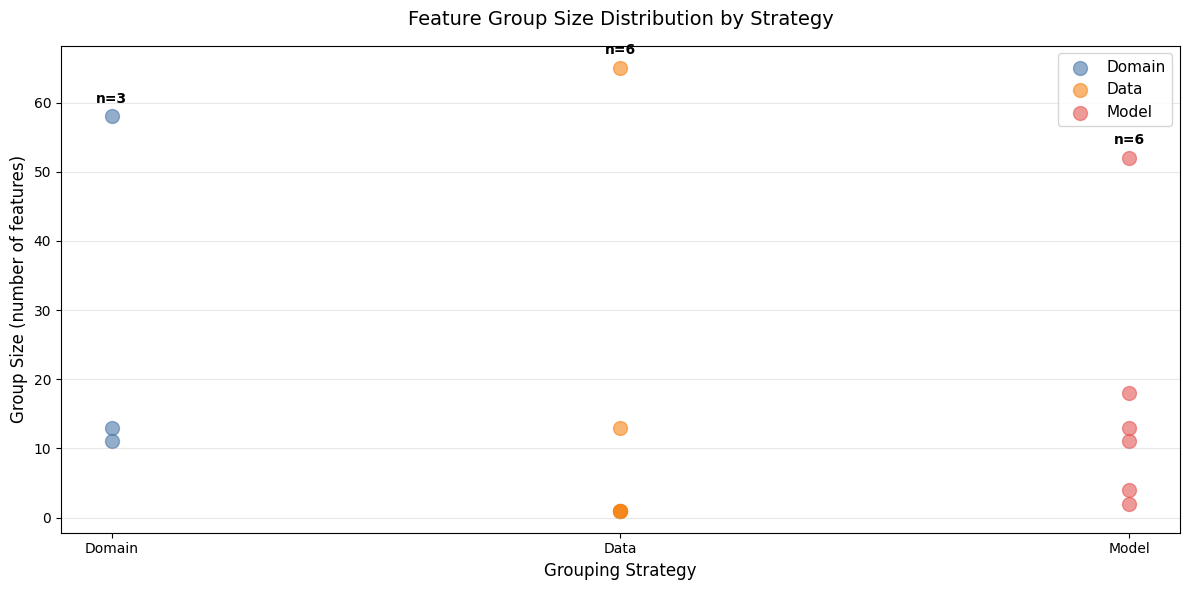



FEATURE OVERLAP BETWEEN GROUPING STRATEGIES

Jaccard Similarity between Strategies:
----------------------------------------
Domain vs Data:
  Jaccard Similarity: 1.0000
  Overlap: 82 features
  Union: 82 features

Domain vs Model:
  Jaccard Similarity: 1.0000
  Overlap: 82 features
  Union: 100 features

Data vs Model:
  Jaccard Similarity: 1.0000
  Overlap: 82 features
  Union: 100 features


Features common to ALL strategies (82 features):
  [  0] cat__gender_2
  [  1] cat__education_1
  [  2] cat__education_2
  [  3] cat__education_3
  [  4] cat__education_4
  [  5] cat__education_5
  [  6] cat__education_6
  [  7] cat__marriage_1
  [  8] cat__marriage_2
  [  9] cat__marriage_3
  [ 10] cat__repayment_status_sep_-2
  [ 11] cat__repayment_status_sep_0
  [ 12] cat__repayment_status_sep_1
  [ 13] cat__repayment_status_sep_2
  [ 14] cat__repayment_status_sep_3
  [ 15] cat__repayment_status_sep_4
  [ 16] cat__repayment_status_sep_5
  [ 17] cat__repayment_status_sep_6
  [ 18] cat__repay

In [2]:
# ============================================================
# OWEN CLUSTER ANALYSIS - PRINT FEATURE GROUPS
# ============================================================

print("\n" + "="*80)
print("OWEN GROUPING - CLUSTER ANALYSIS")
print("="*80)

# Get feature names from preprocessor
fnames = preprocessor.get_feature_names_out()
print(f"\nTotal number of processed features: {len(fnames)}")
print("\nFeature names (first 20):")
for i, name in enumerate(fnames[:20]):
    print(f"  {i:3d}: {name}")

# Function to print cluster details
def print_cluster_details(groups_dict, group_type="Unknown"):
    print(f"\n{group_type} Grouping Strategy:")
    print("-" * 50)

    total_features = sum(len(feats) for feats in groups_dict.values())
    print(f"Number of groups: {len(groups_dict)}")
    print(f"Total features covered: {total_features}")

    for group_name, features in groups_dict.items():
        print(f"\n{group_name} ({len(features)} features):")
        for idx in sorted(features):
            if idx < len(fnames):
                print(f"  [{idx:3d}] {fnames[idx]}")
            else:
                print(f"  [{idx:3d}] Index out of range")

# Analyze Domain Groups
print("\n\n" + "="*80)
print("DOMAIN-BASED GROUPS (Expert Knowledge)")
print("="*80)

dom_groups = build_domain_groups_taiwan(fnames)
print_cluster_details(dom_groups, "Domain-based")

# Analyze Data Groups
print("\n\n" + "="*80)
print("DATA-DRIVEN GROUPS (Correlation Clustering)")
print("="*80)

# Use a sample of training data for clustering
sample_idx = np.random.choice(len(X), min(1000, len(X)), replace=False)
X_sample = X.iloc[sample_idx]
X_proc_sample = preprocessor.transform(X_sample)

data_groups, corr_matrix = build_data_groups(X_proc_sample, n_groups=6)
print_cluster_details(data_groups, "Data-driven")

# Analyze correlation patterns
print(f"\nCorrelation matrix shape: {corr_matrix.shape}")
print(f"Average within-group correlation: {np.mean(corr_matrix):.4f}")

# Analyze Model Groups
print("\n\n" + "="*80)
print("MODEL-DRIVEN GROUPS (SHAP-based Clustering)")
print("="*80)

# Create a simple model to get SHAP values for clustering
from sklearn.ensemble import RandomForestClassifier

# Train a model on a sample
train_idx = np.random.choice(len(X), min(500, len(X)), replace=False)
X_train_sample = X.iloc[train_idx]
y_train_sample = y.iloc[train_idx]

simple_model = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42)
pipe_simple = ImbPipeline([('prep', preprocessor), ('clf', simple_model)])
pipe_simple.fit(X_train_sample, y_train_sample)

# Get SHAP values
bg_sample = X_train_sample.sample(n=min(100, len(X_train_sample)), random_state=42)
shap_vals = get_shap_reliable(pipe_simple, bg_sample)

model_groups, shap_corr = build_model_groups(shap_vals, n_groups=6)
print_cluster_details(model_groups, "Model-driven")

print(f"\nSHAP-based correlation matrix shape: {shap_corr.shape}")
print(f"Average SHAP correlation: {np.mean(shap_corr):.4f}")

# ============================================================
# COMPARATIVE ANALYSIS OF ALL GROUPING STRATEGIES
# ============================================================

print("\n\n" + "="*80)
print("COMPARATIVE GROUPING ANALYSIS")
print("="*80)

all_groupings = {
    "Domain": dom_groups,
    "Data": data_groups,
    "Model": model_groups
}

comparison_df = pd.DataFrame()

for name, groups in all_groupings.items():
    # Calculate group statistics
    group_sizes = [len(feats) for feats in groups.values()]

    stats = {
        'Strategy': name,
        'Num_Groups': len(groups),
        'Avg_Group_Size': np.mean(group_sizes),
        'Std_Group_Size': np.std(group_sizes),
        'Min_Group_Size': min(group_sizes),
        'Max_Group_Size': max(group_sizes),
        'Coverage': sum(group_sizes) / len(fnames) * 100
    }

    comparison_df = pd.concat([comparison_df, pd.DataFrame([stats])], ignore_index=True)

print("\nGrouping Strategy Comparison:")
print("-" * 60)
print(comparison_df.to_string(index=False, float_format=lambda x: f"{x:.2f}" if isinstance(x, float) else str(x)))

# Visualize group sizes
plt.figure(figsize=(12, 6))

# Plot group size distributions
colors = {'Domain': '#4C78A8', 'Data': '#F58518', 'Model': '#E45756'}

for idx, (name, groups) in enumerate(all_groupings.items()):
    group_sizes = [len(feats) for feats in groups.values()]
    plt.scatter([idx] * len(group_sizes), group_sizes,
                s=100, alpha=0.6, label=name, color=colors[name])
    plt.text(idx, max(group_sizes) + 2, f"n={len(groups)}",
             ha='center', fontsize=10, fontweight='bold')

plt.xlabel("Grouping Strategy", fontsize=12)
plt.ylabel("Group Size (number of features)", fontsize=12)
plt.title("Feature Group Size Distribution by Strategy", fontsize=14, pad=15)
plt.xticks([0, 1, 2], ['Domain', 'Data', 'Model'])
plt.legend(fontsize=11)
plt.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('taiwan_group_size_distribution.png', dpi=300)
plt.show()

# ============================================================
# FEATURE OVERLAP ANALYSIS BETWEEN STRATEGIES
# ============================================================

print("\n\n" + "="*80)
print("FEATURE OVERLAP BETWEEN GROUPING STRATEGIES")
print("="*80)

# Convert groups to sets of feature indices
strategy_sets = {}
for name, groups in all_groupings.items():
    all_features = set()
    for feats in groups.values():
        all_features.update(feats)
    strategy_sets[name] = all_features

# Calculate Jaccard similarity between strategies
from sklearn.metrics import jaccard_score

print("\nJaccard Similarity between Strategies:")
print("-" * 40)

strategies = list(strategy_sets.keys())
for i in range(len(strategies)):
    for j in range(i+1, len(strategies)):
        strat1 = strategies[i]
        strat2 = strategies[j]

        set1 = strategy_sets[strat1]
        set2 = strategy_sets[strat2]

        # Create binary vectors
        vec1 = np.array([1 if k in set1 else 0 for k in range(len(fnames))])
        vec2 = np.array([1 if k in set2 else 0 for k in range(len(fnames))])

        jaccard = jaccard_score(vec1, vec2)
        overlap = len(set1.intersection(set2))
        total_union = len(set1.union(set2))

        print(f"{strat1} vs {strat2}:")
        print(f"  Jaccard Similarity: {jaccard:.4f}")
        print(f"  Overlap: {overlap} features")
        print(f"  Union: {total_union} features")
        print()

# Find features that appear in all strategies
common_features = set.intersection(*strategy_sets.values())
print(f"\nFeatures common to ALL strategies ({len(common_features)} features):")
if common_features:
    for idx in sorted(common_features):
        if idx < len(fnames):
            print(f"  [{idx:3d}] {fnames[idx]}")

# Find unique features for each strategy
print("\n\nUnique features per strategy:")
for name, feat_set in strategy_sets.items():
    other_sets = [v for k, v in strategy_sets.items() if k != name]
    unique_features = feat_set - set.union(*other_sets)
    print(f"\n{name} - Unique features ({len(unique_features)}):")
    for idx in sorted(unique_features):
        if idx < len(fnames):
            print(f"  [{idx:3d}] {fnames[idx]}")